In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [145]:
df = pd.read_csv("fundamental_plane.csv")
df

,ID,log_re_arcsec,err_log_re_arcsec,log_re_pc,err_log_re_pc,m,err_m,M,err_M,mu,err_mu,ellip,err_elip,log_sigma,err_log_sigma
0,NGC-57,1.29,0.02,3.70,0.02,11.86,0.44,-21.76,0.44,19.28,0.47,0.17,0.02,2.502,0.025
1,NGC-97,1.18,0.01,3.54,0.01,12.44,0.16,-20.92,0.16,19.55,0.17,0.06,0.02,2.086,0.117
2,NGC-194,1.40,0.01,3.79,0.01,11.94,0.06,-21.55,0.06,20.14,0.08,0.11,0.02,2.332,0.051
3,NGC-221,1.65,0.01,2.16,0.05,7.89,0.21,-16.21,0.31,17.27,0.22,0.17,0.02,1.898,0.055
4,NGC-410,1.62,0.01,4.03,0.01,11.26,0.30,-22.36,0.30,20.37,0.32,0.26,0.02,2.458,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NGC-7785,1.55,0.02,3.80,0.02,11.23,0.17,-21.57,0.17,19.65,0.21,0.44,0.01,2.382,0.045
102,IC-179,1.15,0.01,3.47,0.02,12.45,0.14,-20.73,0.14,19.28,0.17,0.16,0.02,2.447,0.030
103,IC-962,0.80,0.04,3.31,0.04,13.24,0.22,-20.86,0.22,18.31,0.28,0.10,0.01,2.185,0.086
104,IC-1211,1.10,0.02,3.56,0.02,12.75,0.13,-21.11,0.13,19.33,0.17,0.13,0.01,2.212,0.123


In [146]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

In [147]:
log_sigma = df['log_sigma']  # 1.4 * x1
mu = df['mu']  # 0.36 * x2
log_sigma_mu = df[['log_sigma', 'mu']]

log_re = df['log_re_pc']  # y
err_log_re = df['err_log_re_pc']  #err_y.to_numpy()

In [148]:
# creating train and test sets 
log_sigma_mu_train, log_sigma_mu_test, log_re_train, log_re_test = train_test_split( 
    log_sigma_mu, log_re, test_size=0.3, random_state=10)


In [149]:
# Create linear regression object
lin = linear_model.LinearRegression()

# Train the model using the training sets
lin.fit(log_sigma_mu_train, log_re_train)

LinearRegression()

In [150]:
# Make predictions using the testing set
log_re_pred = lin.predict(log_sigma_mu_test)
#log_re_pred = pd.Series(log_re_pred) 

# The coefficients
print('Coefficients: \n', lin.coef_)
print('Intercept: \n', lin.intercept_)
a1, a2 = lin.coef_
a0 = lin.intercept_

Coefficients: 
 [1.08462841 0.28830677]
Intercept: 
 -4.581729111264366


In [151]:
# model evaluation 
print( 
  'mean_squared_error : ', metrics.mean_squared_error(log_re_test, log_re_pred)) 
print( 
  'mean_absolute_error : ', metrics.mean_absolute_error(log_re_test, log_re_pred)) 


# The mean squared error
print("Mean squared error (MSE): %.2f"
      % metrics.mean_squared_error(log_re_test, log_re_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score (coefficient of determination, R2): %.2f' % metrics.r2_score(log_re_test, log_re_pred))

mean_squared_error :  0.0251085826013903
mean_absolute_error :  0.11202247372093456
Mean squared error (MSE): 0.03
Variance score (coefficient of determination, R2): 0.89


In [152]:
log_sigma_mu_train_comb = a0 + a1 * log_sigma_mu_train['log_sigma'] + a2 * log_sigma_mu_train['mu']
log_sigma_mu_test_comb = a0 + a1 * log_sigma_mu_test['log_sigma'] + a2 * log_sigma_mu_test['mu']

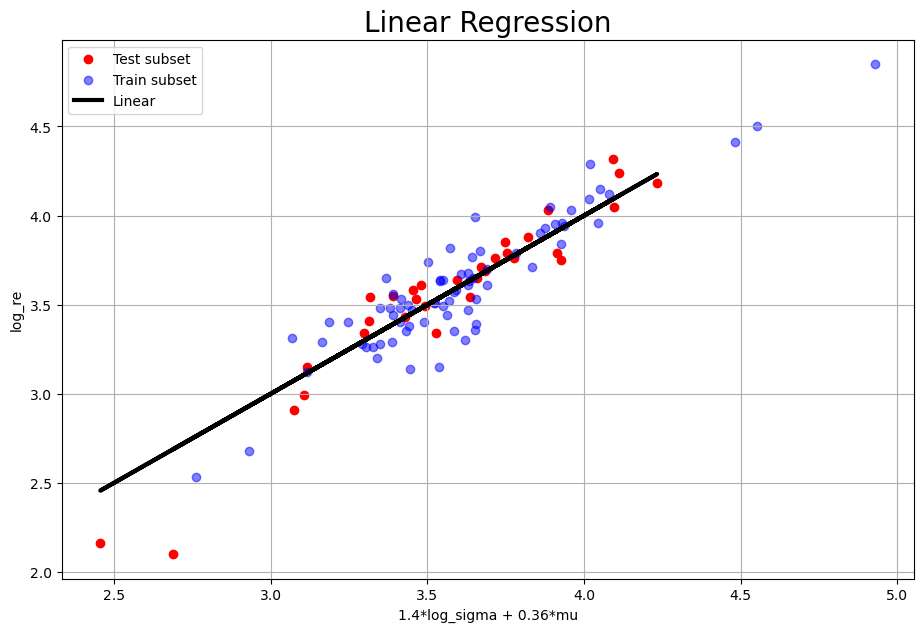

In [153]:
fig, ax = plt.subplots(figsize = (11, 7))

ax.scatter(log_sigma_mu_test_comb, log_re_test, c='r',label = 'Test subset')
ax.scatter(log_sigma_mu_train_comb, log_re_train, c='b',alpha=0.5, label = 'Train subset')
ax.plot(log_sigma_mu_test_comb, log_re_pred, color='k', linewidth=3, label='Linear')
ax.set_xlabel("1.4*log_sigma + 0.36*mu")
ax.set_ylabel("log_re")
plt.title('Linear Regression', size=20)
plt.grid()
plt.legend()

In [154]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [155]:
degrees = np.arange(1, 6, 1)
rms_train = []
rms_test = []
coefs = []
for deg in degrees:
    
    # Polynomial model
    model = Pipeline([('poly', PolynomialFeatures(degree=deg)),
                  ('linear', linear_model.LinearRegression())])
    
    # Train the model using the training sets
    model = model.fit(log_sigma_mu_train, log_re_train)
    
    # The polynomial coefficients
    coefs.append(model.named_steps['linear'].coef_)
    
    # Mean Squared Error (MSE) 
    rmstrain = mean_squared_error(log_re_train, model.predict(log_sigma_mu_train))
    rmstest = mean_squared_error(log_re_test, model.predict(log_sigma_mu_test))

    rms_train.append(rmstrain)
    rms_test.append(rmstest)

In [156]:
coefs[0], coefs[1], coefs[2], coefs[3], coefs[4]

(array([0.        , 1.08462841, 0.28830677]),
 array([ 0.        , -7.65635845,  0.23620489,  0.80283327,  0.25494671,
        -0.01395404]),
 array([ 0.00000000e+00, -1.30339564e+02, -8.78316295e+00,  2.64965604e+01,
         6.70000537e+00,  5.23560897e-02, -2.55986729e+00, -4.25000465e-01,
        -1.11086707e-01,  3.33638062e-03]),
 array([ 0.00000000e+00,  1.65043767e+03,  2.28383230e+02, -6.89014290e+02,
        -9.35098669e+01, -1.15599771e+01,  1.89755010e+02,  4.21492901e+00,
         4.28484875e+00,  2.10575145e-01, -1.47443319e+01, -2.87840606e+00,
         4.05461627e-01, -1.04664416e-01,  5.68822486e-04]),
 array([ 0.00000000e+00, -1.64314671e+04,  3.74901851e+03,  3.92616539e+03,
         2.78685494e+03, -5.11932138e+02,  3.19016135e+03, -1.86693858e+03,
        -4.47548769e+00,  2.49595164e+01, -3.54760682e+02, -1.36899443e+02,
         1.22585137e+02, -9.33422839e+00, -3.32412917e-01, -1.91814912e+00,
         1.77048678e+01, -8.63869159e-01, -2.01248889e+00,  2.3730727

In [157]:
rmstrain

0.01691226855454263

In [158]:
rmstest

0.2285276554686744

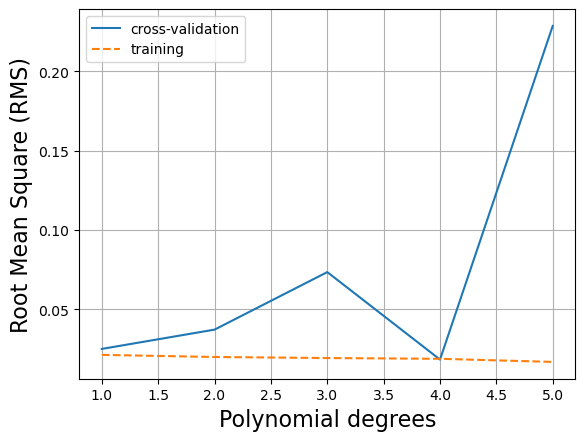

In [159]:
plt.plot(degrees, rms_test, label = "cross-validation")
plt.plot(degrees, rms_train, "--", label = "training")
plt.grid()
plt.xlabel("Polynomial degrees", size=16)
plt.ylabel("Root Mean Square (RMS)", size=16)
plt.legend(loc=0)
plt.show()

In [167]:
degree_cv = 2
model = Pipeline([('poly', PolynomialFeatures(degree=degree_cv)),
                  ('linear', linear_model.LinearRegression())])
model = model.fit(log_sigma_mu_train, log_re_train)
model.named_steps['linear'].coef_ = np.delete(model.named_steps['linear'].coef_, 0)
print('Coefficients: \n', model.named_steps['linear'].coef_)
print('Intercept: \n', model.named_steps['linear'].intercept_)

Coefficients: 
 [-7.65635845  0.23620489  0.80283327  0.25494671 -0.01395404]
Intercept: 
 6.162375770277478


In [169]:
a1, a2, a3, a4, a5 = model.named_steps['linear'].coef_
a0 = model.named_steps['linear'].intercept_


In [170]:
log_sigma_mu_train_comb = a0 + a1 * log_sigma_mu_train['log_sigma'] + a2 * log_sigma_mu_train['mu'] + a3 * log_sigma_mu_train['log_sigma']**2 + a4 * log_sigma_mu_train['mu']**2 + a5 * log_sigma_mu_train['log_sigma'] * log_sigma_mu_train['mu']
log_sigma_mu_test_comb = a0 + a1 * log_sigma_mu_test['log_sigma'] + a2 * log_sigma_mu_test['mu'] + a3 * log_sigma_mu_test['log_sigma']**2 + a4 * log_sigma_mu_test['mu']**2 + a5 * log_sigma_mu_test['log_sigma'] * log_sigma_mu_test['mu']


/home/javier/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


ValueError: Found array with dim 3. PolynomialFeatures expected <= 2.

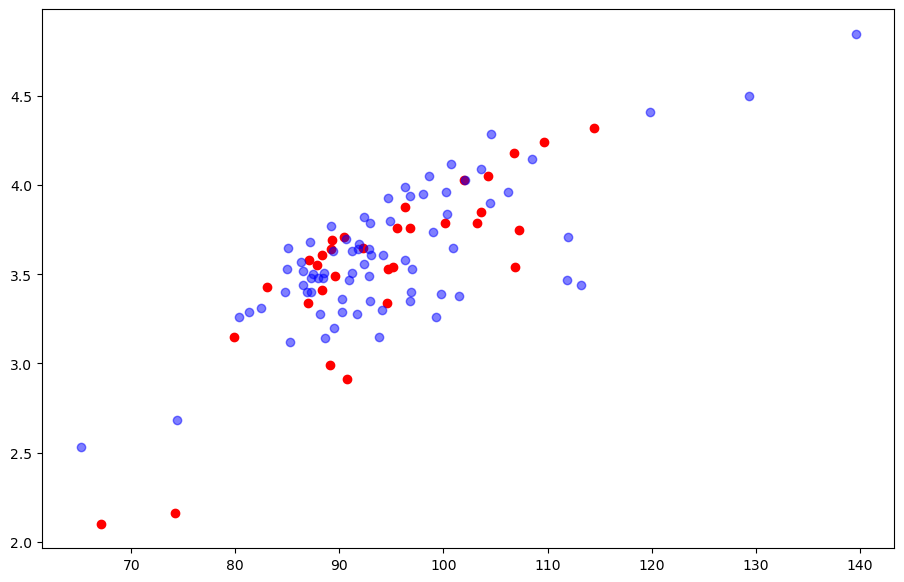

In [181]:
#plt.plot(log_sigma_mu_train_comb, log_re_train, 'ro', alpha=0.5, label = 'Train subset')
#plt.plot(log_sigma_mu_test_comb, log_re_test, 'bo', label = 'Test subset')

#x_to_plot = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)
#plt.plot(x_to_plot, model.predict(x_to_plot.reshape(-1,1)), label='Poly')
#plt.xlabel("X", size=16)
#plt.ylabel("Y", size=16)
#plt.title('Polynomial', size=20)
#plt.grid()
#plt.legend()
#plt.show()

x1_test = np.linspace(60, 141, 1).reshape(-1, 1)
x2_test = np.linspace(60, 141, 1).reshape(-1, 1)
X_test = [x1_test, x2_test]

fig, ax = plt.subplots(figsize = (11, 7))

ax.scatter(log_sigma_mu_test_comb, log_re_test, c='r',label = 'Test subset')
ax.scatter(log_sigma_mu_train_comb, log_re_train, c='b',alpha=0.5, label = 'Train subset')
ax.plot(X_test, model.predict(X_test), color='k', linewidth=3, label='Linear')
ax.set_xlabel("1.4*log_sigma + 0.36*mu")
ax.set_ylabel("log_re")
plt.title('Polynomial', size=20)
plt.grid()
plt.legend()

In [301]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [311]:
# Splitting variables
X = df[['log_sigma', 'mu']].values  # independent
y = df['log_re_pc'].values  # dependent

print(X)
print(y)

# Train linear regression model on whole dataset
lr = LinearRegression()
lr.fit(X, y)

# Train polynomial regression model on the whole dataset
pr = PolynomialFeatures(degree = 2)
X_poly = pr.fit_transform(X)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y)

[[ 2.502 19.28 ]
 [ 2.086 19.55 ]
 [ 2.332 20.14 ]
 [ 1.898 17.27 ]
 [ 2.458 20.37 ]
 [ 2.497 18.86 ]
 [ 2.471 20.52 ]
 [ 2.369 18.9  ]
 [ 2.233 18.91 ]
 [ 2.238 19.05 ]
 [ 2.272 18.96 ]
 [ 2.362 18.84 ]
 [ 2.35  19.27 ]
 [ 2.477 20.2  ]
 [ 2.297 21.45 ]
 [ 2.369 22.77 ]
 [ 2.525 19.51 ]
 [ 2.332 19.43 ]
 [ 2.26  19.14 ]
 [ 2.479 19.82 ]
 [ 2.31  18.93 ]
 [ 2.394 20.94 ]
 [ 2.299 19.51 ]
 [ 2.322 19.83 ]
 [ 2.412 18.66 ]
 [ 2.396 19.47 ]
 [ 2.438 19.41 ]
 [ 2.196 19.25 ]
 [ 2.27  19.79 ]
 [ 2.326 19.42 ]
 [ 2.36  19.33 ]
 [ 2.509 22.   ]
 [ 2.442 19.31 ]
 [ 2.369 18.66 ]
 [ 2.276 18.59 ]
 [ 2.274 19.57 ]
 [ 2.483 20.05 ]
 [ 2.473 20.21 ]
 [ 2.382 19.   ]
 [ 2.408 19.11 ]
 [ 2.563 19.9  ]
 [ 2.265 18.81 ]
 [ 2.316 20.8  ]
 [ 2.246 18.94 ]
 [ 2.412 19.03 ]
 [ 2.26  20.07 ]
 [ 1.74  21.1  ]
 [ 2.53  19.15 ]
 [ 1.991 19.06 ]
 [ 2.418 19.59 ]
 [ 2.471 18.49 ]
 [ 2.045 20.14 ]
 [ 2.408 19.72 ]
 [ 2.057 18.93 ]
 [ 2.    19.91 ]
 [ 2.498 19.13 ]
 [ 2.294 18.23 ]
 [ 2.158 18.58 ]
 [ 2.525 20.6 

LinearRegression()

In [312]:
# Predict results
y_pred_lr = lr.predict(X)           # Linear Regression
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression

In [313]:
# The coefficients
print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
a1, a2 = lr.coef_
a0 = lr.intercept_

Coefficients: 
 [1.16083816 0.3084427 ]
Intercept: 
 -5.155242996448833


In [314]:
X_comb = a0 + a1 * X[:, 0] + a2 * X[:, 1]

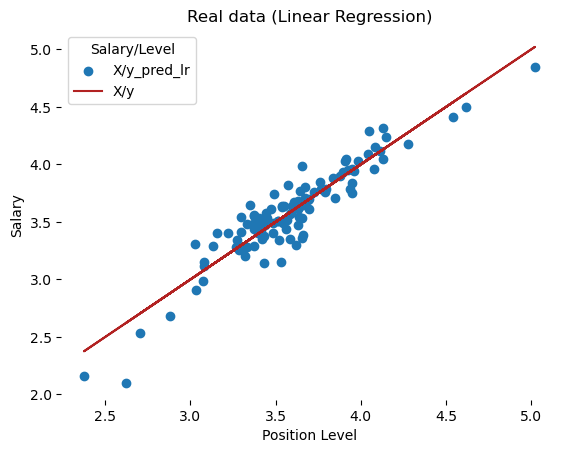

In [315]:
# Visualize real data with linear regression
plt.scatter(X_comb, y)
plt.plot(X_comb, lr.predict(X), color = 'firebrick')
plt.title('Real data (Linear Regression)')
plt.xlabel('Position Level')
plt.ylabel('Salary')
plt.legend(['X/y_pred_lr', 'X/y'], title = 'Salary/Level', loc='best', facecolor='white')
plt.box(False)
plt.show()

In [316]:
# The coefficients
print('Coefficients: \n', lr_2.coef_)
print('Intercept: \n', lr_2.intercept_)

a1, a2, a3, a4, a5 = lr_2.coef_[1], lr_2.coef_[2], lr_2.coef_[3], lr_2.coef_[4], lr_2.coef_[5]
a0 = lr_2.intercept_

Coefficients: 
 [ 0.          2.85628768  1.1345132  -0.19334206 -0.04232295 -0.01830477]
Intercept: 
 -15.256420451427115


In [317]:
X_comb = a0 + a1 * X[:, 0] + a2 * X[:, 1] + a3 * X[:, 0]**2 + a4 * X[:, 1]**2 + a5 * X[:, 0] * X[:, 1]
X_comb

array([-4.06210963, -4.88220713, -4.82462607, -4.16158315, -4.77162036,
       -3.8491297 , -4.84792016, -4.07040124, -4.29586433, -4.35946024,
       -4.25743019, -4.05121119, -4.29463107, -4.63582627, -5.75511365,
       -6.6727748 , -4.15417156, -4.4107724 , -4.37051099, -4.40301074,
       -4.1804018 , -5.2453926 , -4.50819595, -4.65461625, -3.88237594,
       -4.3314644 , -4.23238491, -4.53410355, -4.71474613, -4.41484954,
       -4.31124304, -5.84250058, -4.17126183, -3.95076109, -4.06725177,
       -4.58223671, -4.53449553, -4.64815447, -4.10102121, -4.11735324,
       -4.32292114, -4.19303173, -5.27283383, -4.28974587, -4.06914814,
       -4.89720559, -6.44825379, -3.94928141, -4.78202359, -4.36448905,
       -3.70759608, -5.29569968, -4.45466169, -4.60176158, -5.23510995,
       -3.9877308 , -3.87017689, -4.25819981, -4.81828643, -3.3004627 ,
       -6.24442117, -5.56583014, -3.62376983, -4.66951162, -4.08740975,
       -3.82855733, -3.80682061, -4.89558522, -5.04952137, -4.16

[[-7.28563979]
 [-7.18563979]
 [-7.08563979]
 [-6.98563979]
 [-6.88563979]
 [-6.78563979]
 [-6.68563979]
 [-6.58563979]
 [-6.48563979]
 [-6.38563979]
 [-6.28563979]
 [-6.18563979]
 [-6.08563979]
 [-5.98563979]
 [-5.88563979]
 [-5.78563979]
 [-5.68563979]
 [-5.58563979]
 [-5.48563979]
 [-5.38563979]
 [-5.28563979]
 [-5.18563979]
 [-5.08563979]
 [-4.98563979]
 [-4.88563979]
 [-4.78563979]
 [-4.68563979]
 [-4.58563979]
 [-4.48563979]
 [-4.38563979]
 [-4.28563979]
 [-4.18563979]
 [-4.08563979]
 [-3.98563979]
 [-3.88563979]
 [-3.78563979]
 [-3.68563979]
 [-3.58563979]
 [-3.48563979]
 [-3.38563979]
 [-3.28563979]
 [-3.18563979]
 [-3.08563979]]
[[-7.28563979]
 [-7.18563979]
 [-7.08563979]
 [-6.98563979]
 [-6.88563979]
 [-6.78563979]
 [-6.68563979]
 [-6.58563979]
 [-6.48563979]
 [-6.38563979]
 [-6.28563979]
 [-6.18563979]
 [-6.08563979]
 [-5.98563979]
 [-5.88563979]
 [-5.78563979]
 [-5.68563979]
 [-5.58563979]
 [-5.48563979]
 [-5.38563979]
 [-5.28563979]
 [-5.18563979]
 [-5.08563979]
 [-4.9856

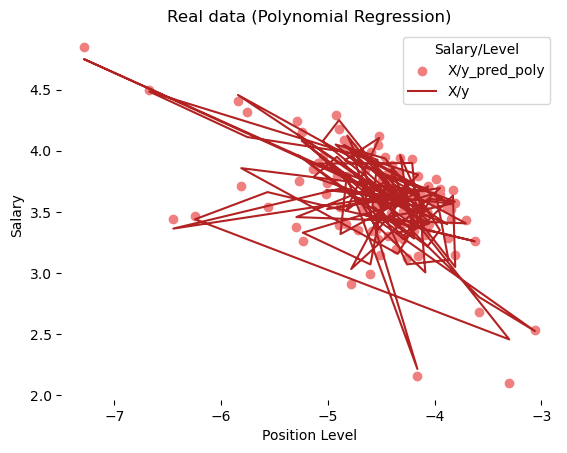

In [318]:
# Visualize real data with polynomial regression
X_grid = np.arange(min(X_comb), max(X_comb), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
print(X_grid)
X_grid = X_grid.reshape((-1, 1))
print(X_grid)
plt.scatter(X_comb, y, color = 'lightcoral')
plt.plot(X_comb, lr_2.predict(X_poly), color = 'firebrick')
plt.title('Real data (Polynomial Regression)')
plt.xlabel('Position Level')
plt.ylabel('Salary')
plt.legend(['X/y_pred_poly', 'X/y'], title = 'Salary/Level', loc='best', facecolor='white')
plt.box(False)
plt.show()

In [357]:
x = df[['log_sigma', 'mu']].values # x

y = df['log_re_pc'].values  # y

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=10)

In [358]:
from sklearn import linear_model

# Create linear regression object
lin = linear_model.LinearRegression()

# Train the model using the training sets
lin.fit(train_x, train_y)

LinearRegression()

In [359]:
# Make predictions using the testing set
y_pred = lin.predict(test_x)

In [360]:
# The coefficients
print('Coefficients: \n', lin.coef_)
print('Intercept: \n', lin.intercept_)
a1, a2 = lin.coef_
a0 = lin.intercept_

print(" ")

# The mean squared error
print("Mean squared error (MSE): %.2f"
      % metrics.mean_squared_error(test_y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score (coefficient of determination, R2): %.2f' % metrics.r2_score(test_y, y_pred))

Coefficients: 
 [1.08462841 0.28830677]
Intercept: 
 -4.581729111264369
 
Mean squared error (MSE): 0.03
Variance score (coefficient of determination, R2): 0.89


In [361]:
train_X_comb = a0 + a1 * train_x[:, 0] + a2 * train_x[:, 1]
test_X_comb = a0 + a1 * test_x[:, 0] + a2 * test_x[:, 1]

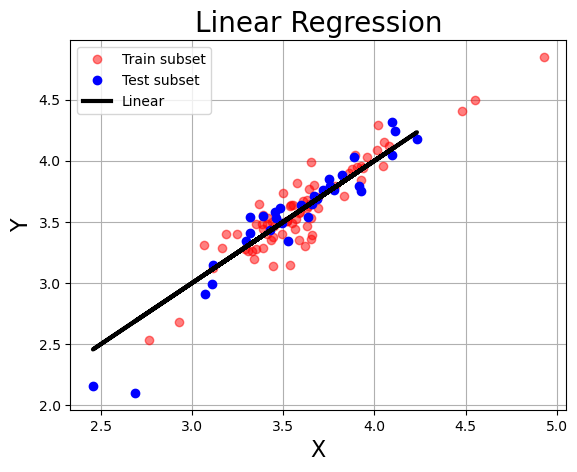

In [362]:
plt.plot(train_X_comb, train_y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test_X_comb, test_y, 'bo', label = 'Test subset')

# Make predictions of our model
plt.plot(test_X_comb, y_pred, color='k', linewidth=3, label='Linear')

plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.title('Linear Regression', size=20)
plt.grid()
plt.legend()
plt.show()

In [363]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', linear_model.LinearRegression())])

model = model.fit(train_x, train_y)
print(model.named_steps['linear'].coef_)
# The mean squared error
print("Mean squared error (MSE): %.2f"
      % mean_squared_error(test_y, model.predict(test_x)))
# Explained variance score: 1 is perfect prediction
print('Variance score (coefficient of determination, R2): %.2f' % r2_score(test_y, model.predict(test_x)))


[ 0.         -7.65635845  0.23620489  0.80283327  0.25494671 -0.01395404]
Mean squared error (MSE): 0.04
Variance score (coefficient of determination, R2): 0.84


In [364]:
# The coefficients
print('Coefficients: \n', model.named_steps['linear'].coef_)
print('Intercept: \n', model.named_steps['linear'].intercept_)
a1, a2, a3, a4, a5 = model.named_steps['linear'].coef_[1], model.named_steps['linear'].coef_[2], model.named_steps['linear'].coef_[3], model.named_steps['linear'].coef_[4], model.named_steps['linear'].coef_[5]
a0 = model.named_steps['linear'].intercept_

Coefficients: 
 [ 0.         -7.65635845  0.23620489  0.80283327  0.25494671 -0.01395404]
Intercept: 
 6.162375770277478


In [365]:
train_X_comb = a0 + a1 * train_x[:, 0] + a2 * train_x[:, 1] + a3 * train_x[:, 0]**2 + a4 * train_x[:, 1]**2 + a5 * train_x[:, 0] * train_x[:, 1]
test_X_comb = a0 + a1 * test_x[:, 0] + a2 * test_x[:, 1] + a3 * test_x[:, 0]**2 + a4 * test_x[:, 1]**2 + a5 * test_x[:, 0] * test_x[:, 1]


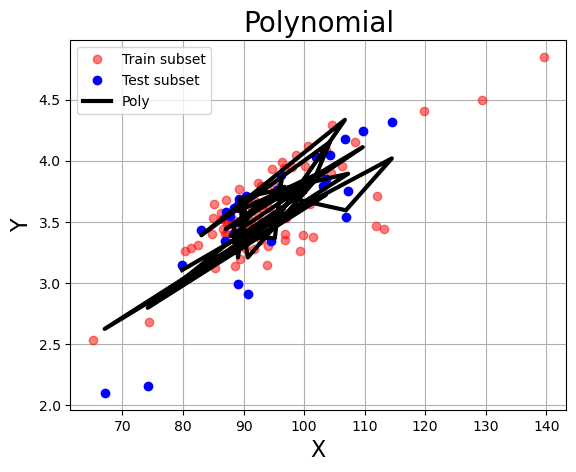

In [391]:
plt.plot(train_X_comb, train_y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test_X_comb, test_y, 'bo', label = 'Test subset')

#x_to_plot = np.linspace(min(test_X_comb) - 0.1, max(test_X_comb) + 0.1, 100)
plt.plot(test_X_comb, model.predict(test_x), color='k', linewidth=3, label='Poly')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.title('Polynomial', size=20)
plt.grid()
plt.legend()
plt.show()

In [386]:
x_to_plot.reshape(-1, 1)

array([[ 66.97174204],
       [ 68.50788987],
       [ 70.0440377 ],
       [ 71.58018553],
       [ 73.11633336],
       [ 74.65248119],
       [ 76.18862902],
       [ 77.72477684],
       [ 79.26092467],
       [ 80.7970725 ],
       [ 82.33322033],
       [ 83.86936816],
       [ 85.40551599],
       [ 86.94166382],
       [ 88.47781165],
       [ 90.01395948],
       [ 91.55010731],
       [ 93.08625514],
       [ 94.62240297],
       [ 96.1585508 ],
       [ 97.69469863],
       [ 99.23084646],
       [100.76699429],
       [102.30314212],
       [103.83928995],
       [105.37543778],
       [106.91158561],
       [108.44773344],
       [109.98388127],
       [111.5200291 ],
       [113.05617693],
       [114.59232476]])

In [387]:
x_to_plot.reshape(1, -1)

array([[ 66.97174204,  68.50788987,  70.0440377 ,  71.58018553,
         73.11633336,  74.65248119,  76.18862902,  77.72477684,
         79.26092467,  80.7970725 ,  82.33322033,  83.86936816,
         85.40551599,  86.94166382,  88.47781165,  90.01395948,
         91.55010731,  93.08625514,  94.62240297,  96.1585508 ,
         97.69469863,  99.23084646, 100.76699429, 102.30314212,
        103.83928995, 105.37543778, 106.91158561, 108.44773344,
        109.98388127, 111.5200291 , 113.05617693, 114.59232476]])

In [394]:
X, y = df[['log_sigma', 'mu']], df['log_re_pc']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)


In [395]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

LinearRegression()

In [398]:
poly_reg_y_predicted = poly_reg_model.predict(X_test)

# The mean squared error
print("Mean squared error (MSE): %.2f"
      % mean_squared_error(y_test, poly_reg_y_predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score (coefficient of determination, R2): %.2f' % r2_score(y_test, poly_reg_y_predicted))


Mean squared error (MSE): 0.02
Variance score (coefficient of determination, R2): 0.80


In [ ]:


train_X_comb = a0 + a1 * train_x[:, 0] + a2 * train_x[:, 1] + a3 * train_x[:, 0]**2 + a4 * train_x[:, 1]**2 + a5 * train_x[:, 0] * train_x[:, 1]
test_X_comb = a0 + a1 * test_x[:, 0] + a2 * test_x[:, 1] + a3 * test_x[:, 0]**2 + a4 * test_x[:, 1]**2 + a5 * test_x[:, 0] * test_x[:, 1]


In [402]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Example data: replace with your own DataFrame (df)
# Assume 'log_sigma' and 'mu' are your features, and 'log_re' is your target
# df = pd.DataFrame({'log_sigma': ..., 'mu': ..., 'log_re': ...})

# Define X (features) and y (target)
X = df[['log_sigma', 'mu']].values
y = df['log_re_pc'].values

# Split the data into training and test sets (70% train, 30% test)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=10)

# Create a pipeline with PolynomialFeatures (degree 2) and LinearRegression
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),  # Second degree polynomial
    ('linear', LinearRegression())
])

# Fit the model to the training data
model.fit(train_x, train_y)

# Print the model's coefficients
print("Coefficients:", model.named_steps['linear'].coef_)
print("Intercept:", model.named_steps['linear'].intercept_)

# Predict on the test data
predictions = model.predict(test_x)

# Optional: Evaluate the model performance (MSE and R2)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [ 0.         -7.65635845  0.23620489  0.80283327  0.25494671 -0.01395404]
Intercept: 6.162375770277478
Mean Squared Error: 0.03725294660183802
R^2 Score: 0.8410498558283132


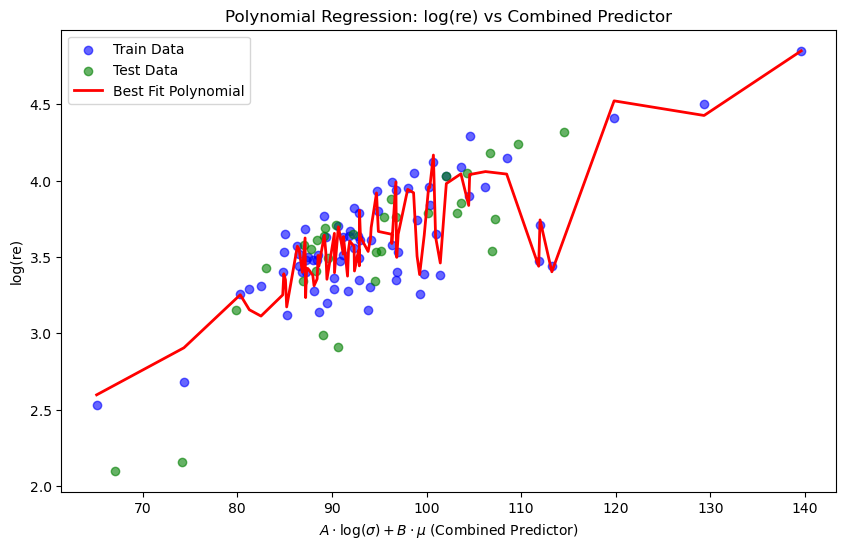

In [404]:
import matplotlib.pyplot as plt

# Extract coefficients for plotting the combined feature
a0 = model.named_steps['linear'].intercept_
coeffs = model.named_steps['linear'].coef_
a1, a2, a3, a4, a5 = coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5]

# Create the combined predictor for train and test data using the model's coefficients
train_combined = a0 + a1 * train_x[:, 0] + a2 * train_x[:, 1] + a3 * train_x[:, 0]**2 + a4 * train_x[:, 1]**2 + a5 * train_x[:, 0] * train_x[:, 1]
test_combined = a0 + a1 * test_x[:, 0] + a2 * test_x[:, 1] + a3 * test_x[:, 0]**2 + a4 * test_x[:, 1]**2 + a5 * test_x[:, 0] * test_x[:, 1]

# Predictions for the training and test data
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

# Plotting
plt.figure(figsize=(10, 6))

# Training data
plt.scatter(train_combined, train_y, color='blue', label="Train Data", alpha=0.6)

# Test data
plt.scatter(test_combined, test_y, color='green', label="Test Data", alpha=0.6)

# Best-fit polynomial line (sorted for better visualization)
sorted_idx = train_combined.argsort()
plt.plot(train_combined[sorted_idx], train_pred[sorted_idx], color='red', linewidth=2, label="Best Fit Polynomial")

# Labels and legend
plt.xlabel(r"$A \cdot \log(\sigma) + B \cdot \mu$ (Combined Predictor)")
plt.ylabel("log(re)")
plt.legend()
plt.title("Polynomial Regression: log(re) vs Combined Predictor")
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

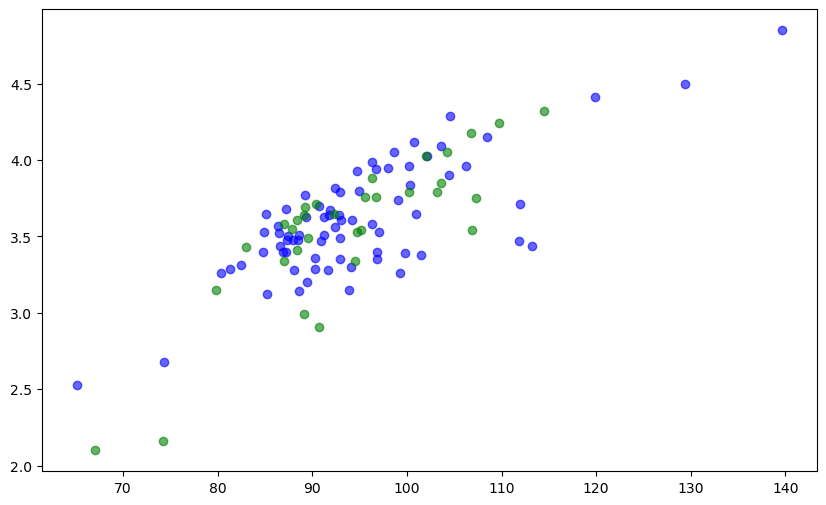

In [405]:
# Plotting
plt.figure(figsize=(10, 6))

# Training data
plt.scatter(train_combined, train_y, color='blue', label="Train Data", alpha=0.6)

# Test data
plt.scatter(test_combined, test_y, color='green', label="Test Data", alpha=0.6)

# Best-fit polynomial line (sorted for better visualization)
#sorted_idx = train_combined.argsort()
#plt.plot(train_combined[sorted_idx], train_pred[sorted_idx], color='red', linewidth=2, label="Best Fit Polynomial")

x_to_plot = np.linspace(min(X) - 0.1, max(X) + 0.1, 100)
plt.plot(x_to_plot, model.predict(x_to_plot.reshape(-1,1)), label='Poly')

# Labels and legend
plt.xlabel(r"$A \cdot \log(\sigma) + B \cdot \mu$ (Combined Predictor)")
plt.ylabel("log(re)")
plt.legend()
plt.title("Polynomial Regression: log(re) vs Combined Predictor")
plt.show()